In [1]:
# ======== BLOQUE 1: IMPORTACIONES ========
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns

In [2]:
# ======== BLOQUE 2: HIPERPARÁMETROS Y CONFIGURACIÓN ========

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hiperparámetros
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
LR_PATIENCE = 5           # ReduceLROnPlateau
EARLYSTOP_PATIENCE = 5    # EarlyStopping

# Directorio de datos (modifica según tu estructura si lo necesitas)
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")

# Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")

print(f"Computando en: {DEVICE}")

Computando en: mps


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import os

# Transformaciones para entrenamiento y validación
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset personalizado para clasificación binaria (positive / negative)
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        for part_dir in self.root_dir.iterdir():
            if part_dir.is_dir() and not part_dir.name.startswith('.'):
                for patient_dir in part_dir.iterdir():
                    if patient_dir.is_dir():
                        for study_dir in patient_dir.iterdir():
                            label = 1 if "positive" in study_dir.name.lower() else 0
                            for img_path in study_dir.glob("*.png"):
                                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Crear datasets
train_dataset = MURABinaryDataset(os.path.join(DATASET_DIR, "train"), transform=transform_train)
valid_dataset = MURABinaryDataset(os.path.join(DATASET_DIR, "valid"), transform=transform_val)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset cargado: {len(train_dataset)} entrenamiento, {len(valid_dataset)} validación")

Dataset cargado: 36808 entrenamiento, 3197 validación


In [4]:
from torchvision import models
import torch.nn as nn

# Cargar modelo ResNet18 preentrenado
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Reemplazar la capa final (fc) para clasificación binaria
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)  # 2 clases: positive / negative

# Congelamos TODAS las capas inicialmente
for param in resnet18.parameters():
    param.requires_grad = False

#  Descongelar las capas layer3 y layer4 para permitir fine-tuning más profundo y la capa fully connected (fc)
for name, param in resnet18.named_parameters():
    if name.startswith("layer3") or name.startswith("layer4"):
        param.requires_grad = True

for param in resnet18.fc.parameters():
    param.requires_grad = True

# Enviar modelo a GPU/MPS/CPU
resnet18 = resnet18.to(DEVICE)

# Verificamos qué parámetros están entrenables
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet18.parameters())
print(f"Parámetros entrenables: {trainable_params:,} / {total_params:,}")

Parámetros entrenables: 10,494,466 / 11,177,538


In [5]:
from collections import Counter

# Extraer etiquetas reales del dataset de entrenamiento
labels = [label for _, label in train_dataset.samples]
class_counts = Counter(labels)

# Mostrar distribución de clases
print(f"Distribución de clases en entrenamiento: {class_counts}")

# Calcular pesos inversos normalizados (más peso a clases menos frecuentes)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]

# Convertir a tensor y enviar a dispositivo
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Revisar los pesos por clase
for i, w in enumerate(class_weights):
    print(f"Clase {i} peso: {w:.2f}")

Distribución de clases en entrenamiento: Counter({0: 21935, 1: 14873})
Clase 0 peso: 1.68
Clase 1 peso: 2.47


In [6]:
# Función de pérdida con pesos por clase para lidiar con desbalance
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador: solo se optimizan las capas descongeladas (layer4 y fc)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler que reduce el LR si el val_loss no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=LR_PATIENCE, verbose=True)

# Para guardar los mejores resultados
best_val_loss = float('inf')
best_f1 = 0
epochs_no_improve = 0

# Histórico de entrenamiento
train_losses = []
val_losses = []
f1_scores = []

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch

def fit(model, train_loader, valid_loader, epochs):
    global best_val_loss, best_f1, epochs_no_improve

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validación
        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(valid_loader.dataset)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        # Métricas
        f1 = f1_score(y_true, y_pred, average='weighted')
        acc = accuracy_score(y_true, y_pred)
        f1_scores.append(f1)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
              f"| Acc: {acc:.4f} | F1: {f1:.4f}")

        # Guardar el mejor modelo
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_f1 = f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV8.pt")
            print("Mejor modelo guardado.")
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("Early stopping activado.")
            break

In [10]:
# Entrenamiento del modelo
fit(resnet18, train_loader, valid_loader, EPOCHS)

Epoch 1 | Train Loss: 0.5387 | Val Loss: 0.4905 | Acc: 0.7732 | F1: 0.7716
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4804 | Val Loss: 0.5037 | Acc: 0.7848 | F1: 0.7820
Epoch 3 | Train Loss: 0.4573 | Val Loss: 0.4820 | Acc: 0.7957 | F1: 0.7934
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.4378 | Val Loss: 0.4743 | Acc: 0.7807 | F1: 0.7805
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.4228 | Val Loss: 0.4682 | Acc: 0.8001 | F1: 0.7994
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.4037 | Val Loss: 0.4767 | Acc: 0.7829 | F1: 0.7828
Epoch 7 | Train Loss: 0.3855 | Val Loss: 0.4775 | Acc: 0.8070 | F1: 0.8048
Epoch 8 | Train Loss: 0.3663 | Val Loss: 0.5056 | Acc: 0.8033 | F1: 0.8013
Epoch 9 | Train Loss: 0.3510 | Val Loss: 0.4990 | Acc: 0.8023 | F1: 0.8013
Epoch 10 | Train Loss: 0.3297 | Val Loss: 0.5448 | Acc: 0.7939 | F1: 0.7923
Early stopping activado.


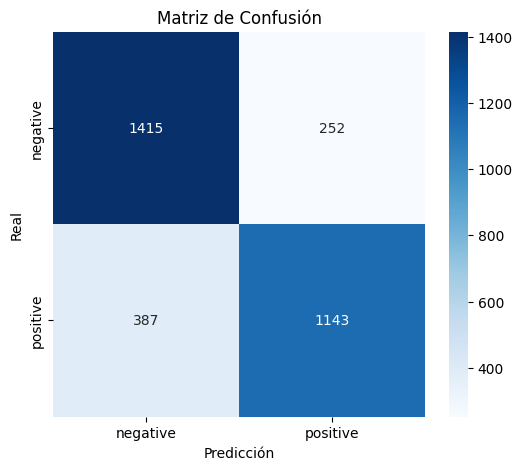

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.85      0.82      1667
    positive       0.82      0.75      0.78      1530

    accuracy                           0.80      3197
   macro avg       0.80      0.80      0.80      3197
weighted avg       0.80      0.80      0.80      3197



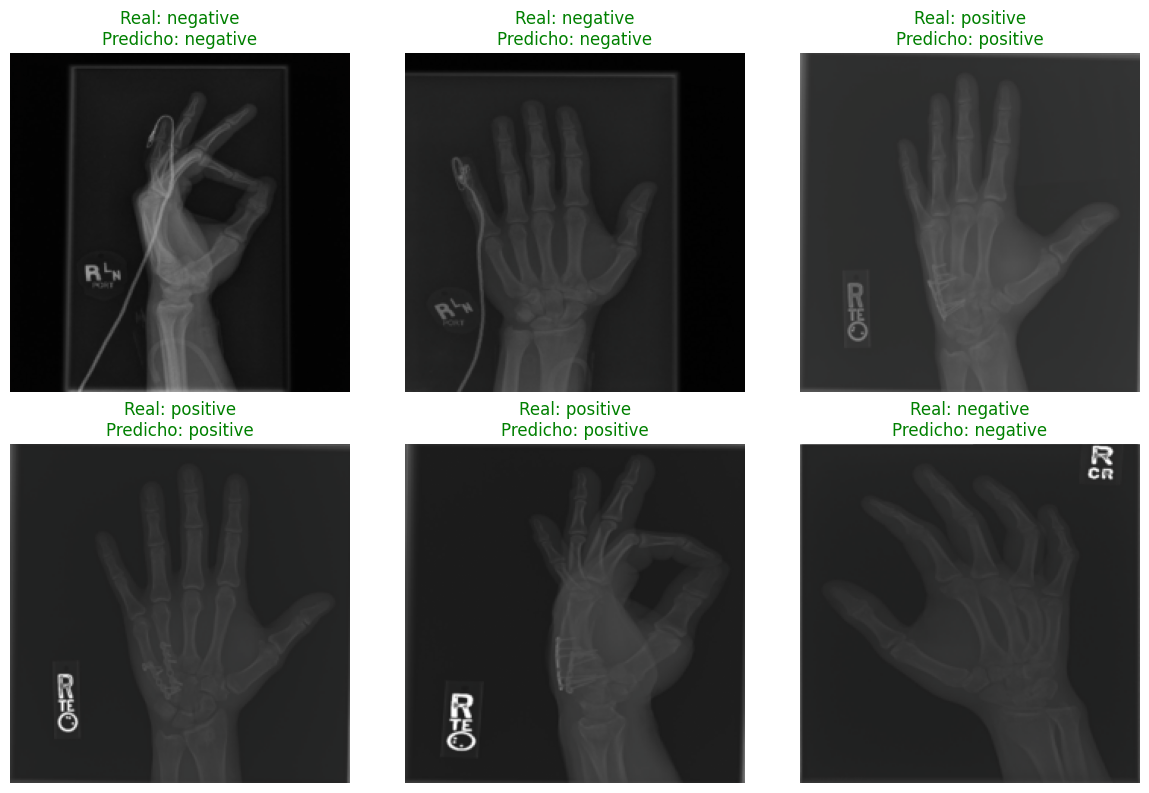

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Asegurarse de que el modelo está en modo evaluación
resnet18.load_state_dict(torch.load("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV8.pt"))
resnet18.eval()

y_true = []
y_pred = []
images_to_show = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Guardar algunas imágenes para mostrar
        if len(images_to_show) < 6:
            for i in range(inputs.size(0)):
                if len(images_to_show) >= 6:
                    break
                images_to_show.append(inputs[i].cpu())
                true_labels.append(labels[i].item())
                pred_labels.append(preds[i].item())

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Mostrar predicciones
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, img in enumerate(images_to_show):
    img = img.permute(1, 2, 0)  # Reordenar canales para mostrar
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Desnormalizar
    img = img.clamp(0, 1)  # Asegurarse de que esté en rango [0,1]

    axs[i].imshow(img.numpy())
    axs[i].axis('off')
    axs[i].set_title(f"Real: {'positive' if true_labels[i] else 'negative'}\n"
                     f"Predicho: {'positive' if pred_labels[i] else 'negative'}",
                     color='green' if true_labels[i] == pred_labels[i] else 'red')

plt.tight_layout()
plt.show()

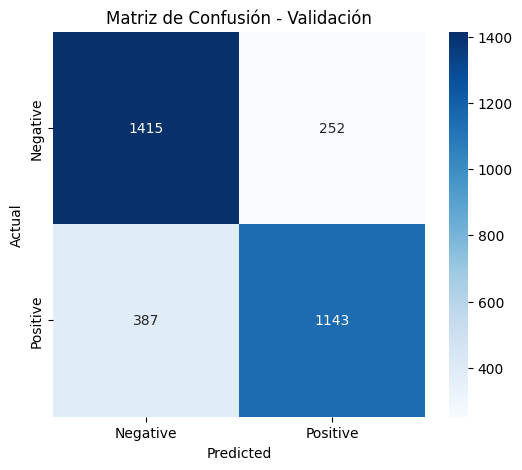

🔍 Mostrando 9 errores de clasificación:


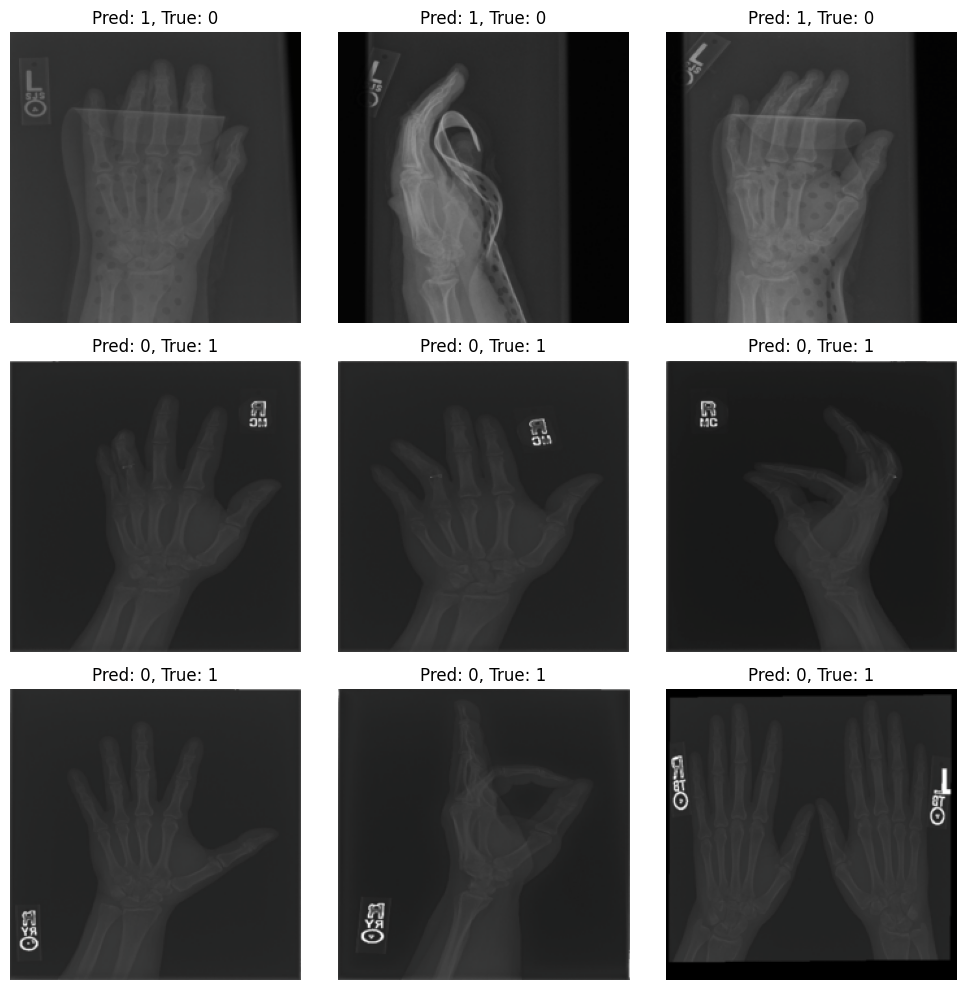

In [14]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Asegurarse de estar en modo evaluación
resnet18.load_state_dict(torch.load("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV8.pt"))
resnet18.eval()

# Obtener predicciones y etiquetas verdaderas
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu())  # para visualizar imágenes luego

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión - Validación")
plt.show()

# Mostrar imágenes mal clasificadas
incorrect_indices = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]
print(f"🔍 Mostrando {min(9, len(incorrect_indices))} errores de clasificación:")

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for i, idx in enumerate(incorrect_indices[:9]):
    img = all_images[idx].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # desnormalizar
    img = np.clip(img, 0, 1)

    axs[i].imshow(img)
    axs[i].set_title(f"Pred: {all_preds[idx]}, True: {all_labels[idx]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()